<a href="https://colab.research.google.com/github/samarth-sudo/Assignment-2-EC500/blob/main/Copy_of_Homework2_EC500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2


Instructions: Click **Copy to drive** at the menu bar, and enter your solutions.

Submission: Please upload your completed **solution .ipynb file and printed PDF file** to [Gradescope](https://www.gradescope.com/courses/707758) (Entry code: WBZX8R) by **March 18, 10PM EST**.

In [ ]:
# install required package
!pip3 install nibabel
!pip3 install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.3 MB/s eta 0:00:00


In [ ]:
# Setting up various plot functions to be used throughout the notebook

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

import nibabel as nib
import os
import SimpleITK as sitk

# plot one or a list of images
def plot_images(images, title=None, figsize=(15,15)):
    f, axes = plt.subplots(1, len(images), figsize=figsize)
    for image_id, image in enumerate(images):
        axes[image_id].imshow(image, cmap='gray')
        axes[image_id].axis('off')
        if not title:
            axes[image_id].set_title('Image {}'.format(image_id), fontsize=20)
        elif len(title) == 1:
            axes[image_id].set_title('Image {}: {}'.format(image_id, title[0]), fontsize=20)
        else:
            axes[image_id].set_title('Image {}: {}'.format(image_id, title[image_id]), fontsize=20)
    f.tight_layout()


def plot_grids(grids, figsize=(15,15)):
    f, axes = plt.subplots(1, len(grids), figsize=figsize)
    for grid_id, grid in enumerate(grids):
        grid_array = sitk.GetArrayViewFromImage(grid)
        axes[grid_id].imshow(np.flip(grid_array, axis=0),
               interpolation='hamming',
               cmap='gray',
               origin='lower')
        axes[grid_id].axis('off')
        axes[grid_id].set_title('Grid {}'.format(grid_id), fontsize=20)
    f.tight_layout()


def plot_grids_and_images(grids, images, figsize=(15,15)):
    f, axes = plt.subplots(1, len(grids), figsize=figsize)
    for grid_id, grid in enumerate(grids):
        grid_array = sitk.GetArrayViewFromImage(grid)
        axes[grid_id].imshow(np.flip(grid_array/np.max(grid_array)*images[grid_id]/np.max(images[grid_id]), axis=0),
               interpolation=None,
               cmap='gray',
               origin='lower')
        axes[grid_id].axis('off')
        axes[grid_id].set_title('Grid overlay {}'.format(grid_id), fontsize=20)
    f.tight_layout()

# function used to plot histograms
def plot_histograms(images, figsize=(15,7.5)):
    f, axes = plt.subplots(1, len(images), figsize=figsize)
    for image_id, image in enumerate(images):
        histogram, bins = np.histogram(image, bins=40)
        axes[image_id].set_xlim([0, 120])
        axes[image_id].hist(histogram, bins)
        axes[image_id].set_title('Image {} Histogram'.format(image_id), fontsize=20)
    f.tight_layout()

# Exercise 1. Histogram Normalisation (30 points)
Histogram normalisation is the process of standardising contrasts across an imaging dataset. We do this to limit the capacity of the network spent to model contrast differences across images in tasks such as segmentation, registration, and volumetric measurements. We will go through the step by step process of histogram normalisation on a hippocampus dataset.
  
While histogram normalisation can be done on a case-by-case basis, given a dataset spanning a number of subjects we would like to normalise them all to a common intensity profile. This can be accomplished according to the details in [this](https://ieeexplore.ieee.org/iel5/42/18064/00836373.pdf) paper, the main details of which we'll cover here.  

The process is as follows:

1. A range of percentiles for standardisation are chosen, e.g.: 10, 20, 30, 40, ..., 90
2. Calculate value of percentiles (i.e.: landmarks) for each of the "train" images
3. Calculate a linear mapping between the intensities of the [min, max] percentiles and the limits of the new "standard" scale (e.g.: [0, 100]).
4. Apply this mapping to each landmark
5. Average the mapped landmarks across all the train images to obtain an average mapping
6. Apply this mapping on any new images (Of the same modality!)

You will want to read how these two functions work to complete the exercise (**Hint**: When calling interp1d you will want to set the fill_value flag to 'extrapolate'):
1. [np.percentile](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html)
2. [interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)

This should be implemented using default linear interpolation, which implements the following mapping between the original intensities, $x$, and a new intensity space $x'$:

<center> $x' = s_1 + \frac{x - p_{1}}{p_2-p_1}(s_2 - s_1)$ </center>

Here, [$s_1, s_2$] are the min and max intensities of the new scale and [$p_1, p_2$] are the min and max landmarks for the original image.

Let's first begin by just loading in the dataset:

In [ ]:
# Download images
file_download_link = "https://github.com/lisun-ai/EC500/raw/main/imgs/Homework2_Hippocampus.tar"
!wget -O Homework2_Hippocampus.tar --no-check-certificate "$file_download_link"
!tar -xf Homework2_Hippocampus.tar

--2024-03-10 20:55:13--  https://github.com/lisun-ai/EC500/raw/main/imgs/Homework2_Hippocampus.tar
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lisun-ai/EC500/main/imgs/Homework2_Hippocampus.tar [following]
--2024-03-10 20:55:13--  https://raw.githubusercontent.com/lisun-ai/EC500/main/imgs/Homework2_Hippocampus.tar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19384320 (18M) [application/octet-stream]
Saving to: ‘Homework2_Hippocampus.tar’

Homework2_Hippocamp 100%[===================>]  18.49M  --.-KB/s    in 0.1s    

2024-03-10 20:55:14 (142 MB/s) - ‘Homework2_Hippocampus.tar’ saved [193

In [ ]:
def read_file(filename):
    img = nib.load(filename)
    data = img.get_fdata()
    aff = img.affine
    return data, aff

# Build the 2D dataset: Let's take 20 images
dataset = []
data_dir = 'Homework2_Hippocampus/imagesTr'
images = os.listdir(data_dir)
for entry in range(20):
    image, _ = read_file(data_dir + '/' + images[entry])
    # Let's take the middle slice and normalise
    dataset.append(100 * image[:, :, 17] / np.max(image[:, :, 17]))

You may begin coding the training function in the cell below:

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

def calc_landmarks_from_percentiles(image, percentile_list):
    landmarks = np.percentile(image, percentile_list)
    return landmarks

def create_trained_mapping(images, percentile_list, scale_min, scale_max, p_min, p_max):
    average_mapped_landmarks = np.zeros(len(percentile_list),)
    for image in images:
        # 1.2. Calculate the landmarks for each image
        landmarks = calc_landmarks_from_percentiles(image, percentile_list)
        # 1.3.  Calculate the image intensities corresponding to your chosen minimum and maximum percentiles
        intensity_min = np.percentile(image, p_min)
        intensity_max = np.percentile(image, p_max)
        # 1.4. Create mapping by interpolating between the image's min + max values and those of the standard scale
        mapping = interp1d([intensity_min, intensity_max], [scale_min, scale_max], fill_value='extrapolate')
        # 1.5. Map the image landmarks to these values
        mapped_landmarks = mapping(landmarks)
        # Sum the mapped landmarks iteratively
        average_mapped_landmarks += mapped_landmarks
    # Average the summed landmarks
    average_mapped_landmarks = average_mapped_landmarks / len(images)
    return average_mapped_landmarks

Now that we've coded the mapping training function I'd like you to code a function that applies the learned mapping to a new image, and test the method:

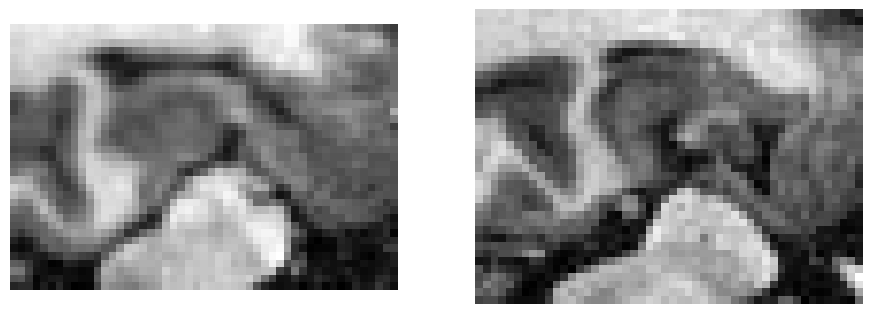

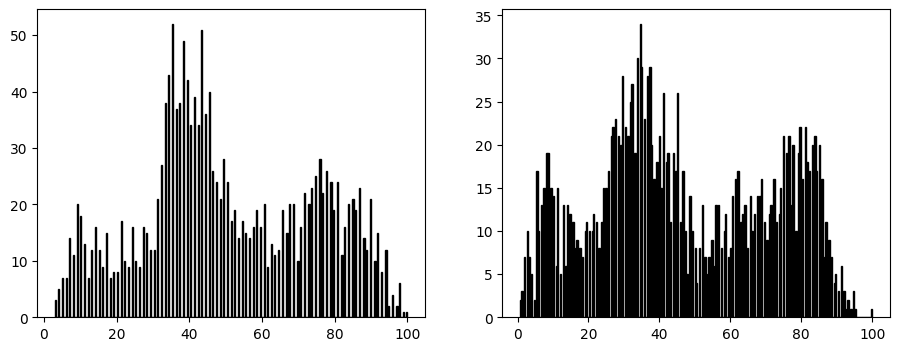

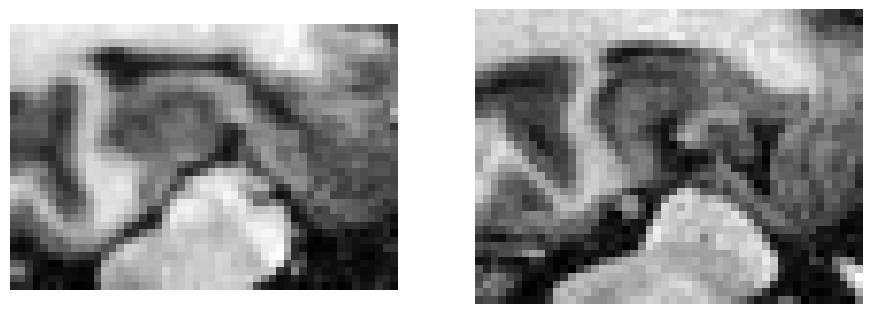

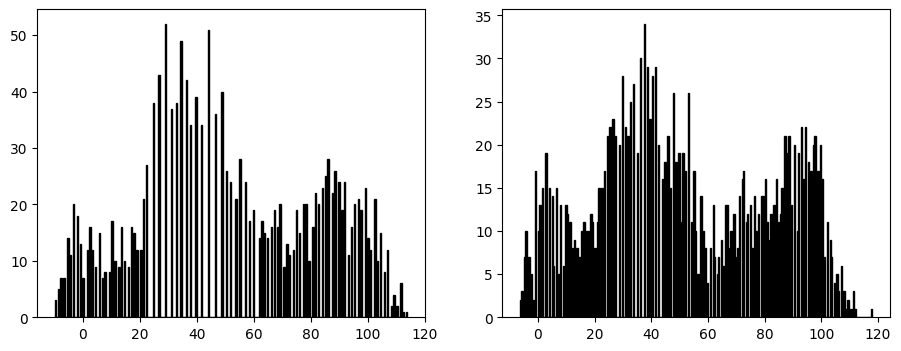

In [ ]:
# 1.6. Code function to apply mapped landmarks to a new image
def standardise_image(image, percentile_list, average_mapped_landmarks):
    # Calculate the landmarks for the image
    landmarks = calc_landmarks_from_percentiles(image, percentile_list)
    # Calculate mapping between the landmarks of this image and the averaged mapped landmarks
    mapping = interp1d(landmarks, average_mapped_landmarks, fill_value='extrapolate')
    vectorized_mapping = np.vectorize(mapping)
    # Apply this mapping to the new image
    new_image = vectorized_mapping(image)
    return new_image

import matplotlib.pyplot as plt

def plot_images(images, figsize=(10, 5)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, image in zip(axes, images):
        ax.imshow(image, cmap='gray')
        ax.axis('off')
    plt.show()

def plot_histograms(images, figsize=(10, 5)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, image in zip(axes, images):
        ax.hist(image.ravel(), bins=256, fc='black', ec='black')
    plt.show()

# Test the method
percentile_list = [10, 20, 30, 40, 50, 60, 70, 80, 90]
trained_mapping = create_trained_mapping(images=dataset[3:],
                                         percentile_list = percentile_list,
                                         scale_min=0, scale_max=100,
                                         p_min=5, p_max=95)

normalised_images = []
for image in dataset[14:16]:
    normalised_images.append(standardise_image(image, percentile_list, trained_mapping))

# Before
plot_images(dataset[14:16], figsize=(11, 11))
plot_histograms(dataset[14:16], figsize=(11, 4))

# After
plot_images(normalised_images, figsize=(11, 11))
plot_histograms(normalised_images, figsize=(11, 4))

# Exercise 2. Bias field correction (15 points)


MRI images will sometimes exhibit a form of corruption termed *bias* or *intensity inhomogeneities*. They arise as a result of imperfections in the imaging pipeline, and cause low-frequency intensity changes across the image as shown in the figure below:
<br>
<div>
<center>
<img src="https://github.com/pedrob37/AML_Lecture4/blob/master/AML_images/BiasFieldImage.png?raw=true" width="750"/>
</center>
</div>

> __Figure__: Coronal brain slice corrupted by a bias field (Left). Corresponding bias field map (Right).  
>[A review of methods for correction of intensity inhomogeneity in MRI.](https://www.ncbi.nlm.nih.gov/pubmed/17354645)  


### Load Image
Download the sample image [here](https://drive.google.com/file/d/1HPiEWhgJ9WVGypdkHauKe4WequzhVLVO/view?usp=sharing).

In [ ]:
import SimpleITK as sitk

In [ ]:
raw_img_path = 'img_hw2_q2.nii.gz'
raw_img_sitk = sitk.ReadImage(raw_img_path, sitk.sitkFloat32)
raw_img_sitk = sitk.DICOMOrient(raw_img_sitk,'RPS')

raw_img_sitk_arr = sitk.GetArrayFromImage(raw_img_sitk)

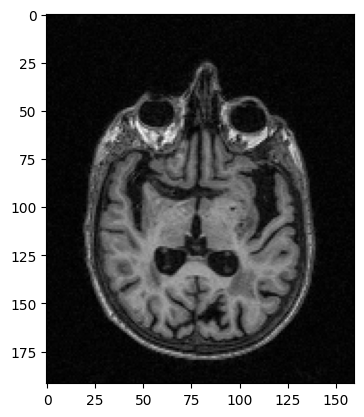

In [ ]:
plt.imshow(raw_img_sitk_arr[96], cmap='gray')
plt.show()

### Create head mask

In order to perform correction on the brain region only, we use thresholding method to get the brain mask. Complete the code below to use Otsu thresholding method to get the brain mask. SimpleITK already provides the Otsu thresholding function.

Read more about Otsu thresholding [here](https://en.wikipedia.org/wiki/Otsu%27s_method).

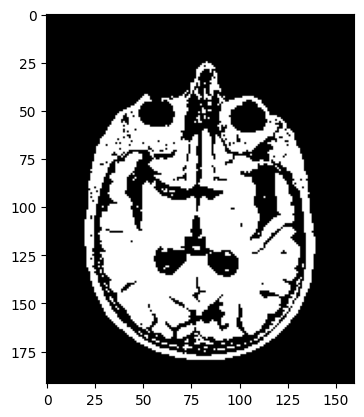

In [ ]:
transformed_img = sitk.RescaleIntensity(raw_img_sitk, 0, 255)

# YOUR CODE HERE
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(0)  # Value for intensities inside the threshold (background)
otsu_filter.SetOutsideValue(1)  # Value for intensities outside the threshold (foreground/brain)
head_mask = otsu_filter.Execute(transformed_img)

head_mask_npy = sitk.GetArrayFromImage(head_mask)

plt.imshow(head_mask_npy[96], cmap='gray')
plt.show()

### Bias Correction
Since bias correction can be time consuming, we typically shrink the image to reduce the size. Complete the code below to use SimpleITK to shrink the image by a factor of 4.

**Hint:** Use the sitk.Shrink function.

In [ ]:
shrinkFactor = 4
inputImage = raw_img_sitk

print('Before:', raw_img_sitk.GetSize())
inputImage = sitk.Shrink(inputImage, [shrinkFactor] * inputImage.GetDimension())

# If you have a mask and want to shrink it as well, apply the same operation
# Assuming 'head_mask' is the original 3D SimpleITK image mask
inputMask = sitk.Shrink(head_mask, [shrinkFactor] * head_mask.GetDimension())
print('After:', inputImage.GetSize())

Before: (160, 192, 192)
After: (40, 48, 48)


In [ ]:
bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()

corrected = bias_corrector.Execute(inputImage, inputMask)

### Inspect the bias field

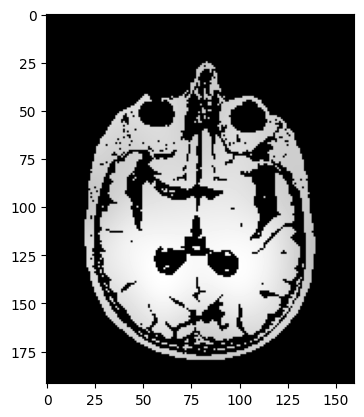

In [ ]:
log_bias_field = bias_corrector.GetLogBiasFieldAsImage(raw_img_sitk)
bias_field = sitk.Exp(log_bias_field)
bias_field = sitk.Mask(bias_field, head_mask)

bias_field_arr = sitk.GetArrayFromImage(bias_field)

plt.imshow(bias_field_arr[96], cmap='gray')
plt.show()

### Get corrected image

Since you have obtained the log bias field, now please finish the last step by apply it to the input raw image by: input/exp(log_bias_field).

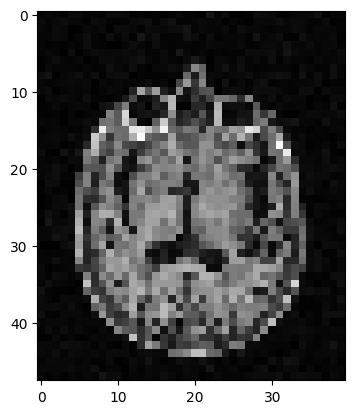

In [ ]:
bias_field = sitk.Exp(log_bias_field)

resample = sitk.ResampleImageFilter()
resample.SetReferenceImage(inputImage)
resample.SetInterpolator(sitk.sitkLinear)
resample.SetTransform(sitk.Transform())
resample.SetOutputSpacing(inputImage.GetSpacing())
resample.SetSize(inputImage.GetSize())
resample.SetOutputDirection(inputImage.GetDirection())
resample.SetOutputOrigin(inputImage.GetOrigin())
resample.SetDefaultPixelValue(1)  # Default value for pixels outside the input image

resampled_bias_field = resample.Execute(sitk.Exp(log_bias_field))
corrected_full_res = inputImage / resampled_bias_field
corrected_full_res_arr = sitk.GetArrayFromImage(corrected_full_res)

plt.imshow(corrected_full_res_arr[96 // 4], cmap='gray')
plt.show()

# Exercise 3. Image Resampling (15 points)
**Background:** Image resampling is a process of changing the pixel or voxel size of an image without altering its spatial extent in the patient coordinate system. It is often used to standardize the image resolution across a data set that contains images from different scanners or modalities. It can also help to align images from different sources, extract regions of interest.

**Task:** Download the image [here](https://drive.google.com/file/d/1Q4U5cvZJQsdUcf1fGZKmkjnsoIzY45MF/view?usp=sharing) and the mask [here](https://drive.google.com/file/d/1UxYd0Gg9W0OxudCUFYr93kzTeu9lKcck/view?usp=sharing).
1. Complete the code below to use SimplITK to resample the image to to 1mm isotropic.

In [ ]:
img = sitk.ReadImage('img_hw2_q3_19676E.nii.gz')
mask = sitk.ReadImage('mask_hw2_q3_19676E.nii.gz')

In [ ]:
def convert_to_isotropic(inputVolume, isoSpacing=1.0):

    inputSpacing = inputVolume.GetSpacing()
    inputSize = inputVolume.GetSize()
    newSpacing = [isoSpacing, isoSpacing, isoSpacing]
    newSize = [int(round(inputSize[0] * (inputSpacing[0] / isoSpacing))),
               int(round(inputSize[1] * (inputSpacing[1] / isoSpacing))),
               int(round(inputSize[2] * (inputSpacing[2] / isoSpacing)))]
    #Resample the images to make them iso-tropic
    resampleFilter = sitk.ResampleImageFilter()
    resampleFilter.SetOutputSpacing(newSpacing)
    resampleFilter.SetSize(newSize)
    resampleFilter.SetTransform(sitk.Transform())
    resampleFilter.SetInterpolator(sitk.sitkLinear)

    # Additional settings to keep the origin and direction the same
    resampleFilter.SetOutputOrigin(inputVolume.GetOrigin())
    resampleFilter.SetOutputDirection(inputVolume.GetDirection())

    resampleVolume = resampleFilter.Execute(inputVolume)

    return resampleVolume

In [ ]:
img_converted = convert_to_isotropic(img, isoSpacing=1.0)

2. Set the origin coordinates of the image to be the same as the mask.

In [ ]:
mask_origin = mask.GetOrigin()
img.SetOrigin(mask_origin)
file = img_converted.SetOrigin(mask_origin)
outputFilePath = 'img_converted2.nii.gz'
sitk.WriteImage(img_converted, outputFilePath)
print(f'Resampled image saved to {outputFilePath}')


Resampled image saved to img_converted2.nii.gz


3. If you have done the resampling correctly, you should be able to overlay the segmentation mask on top of the image using ITK-SNAP. Attach a screen shot of overlayed segmentation on ITK-SNAP below.

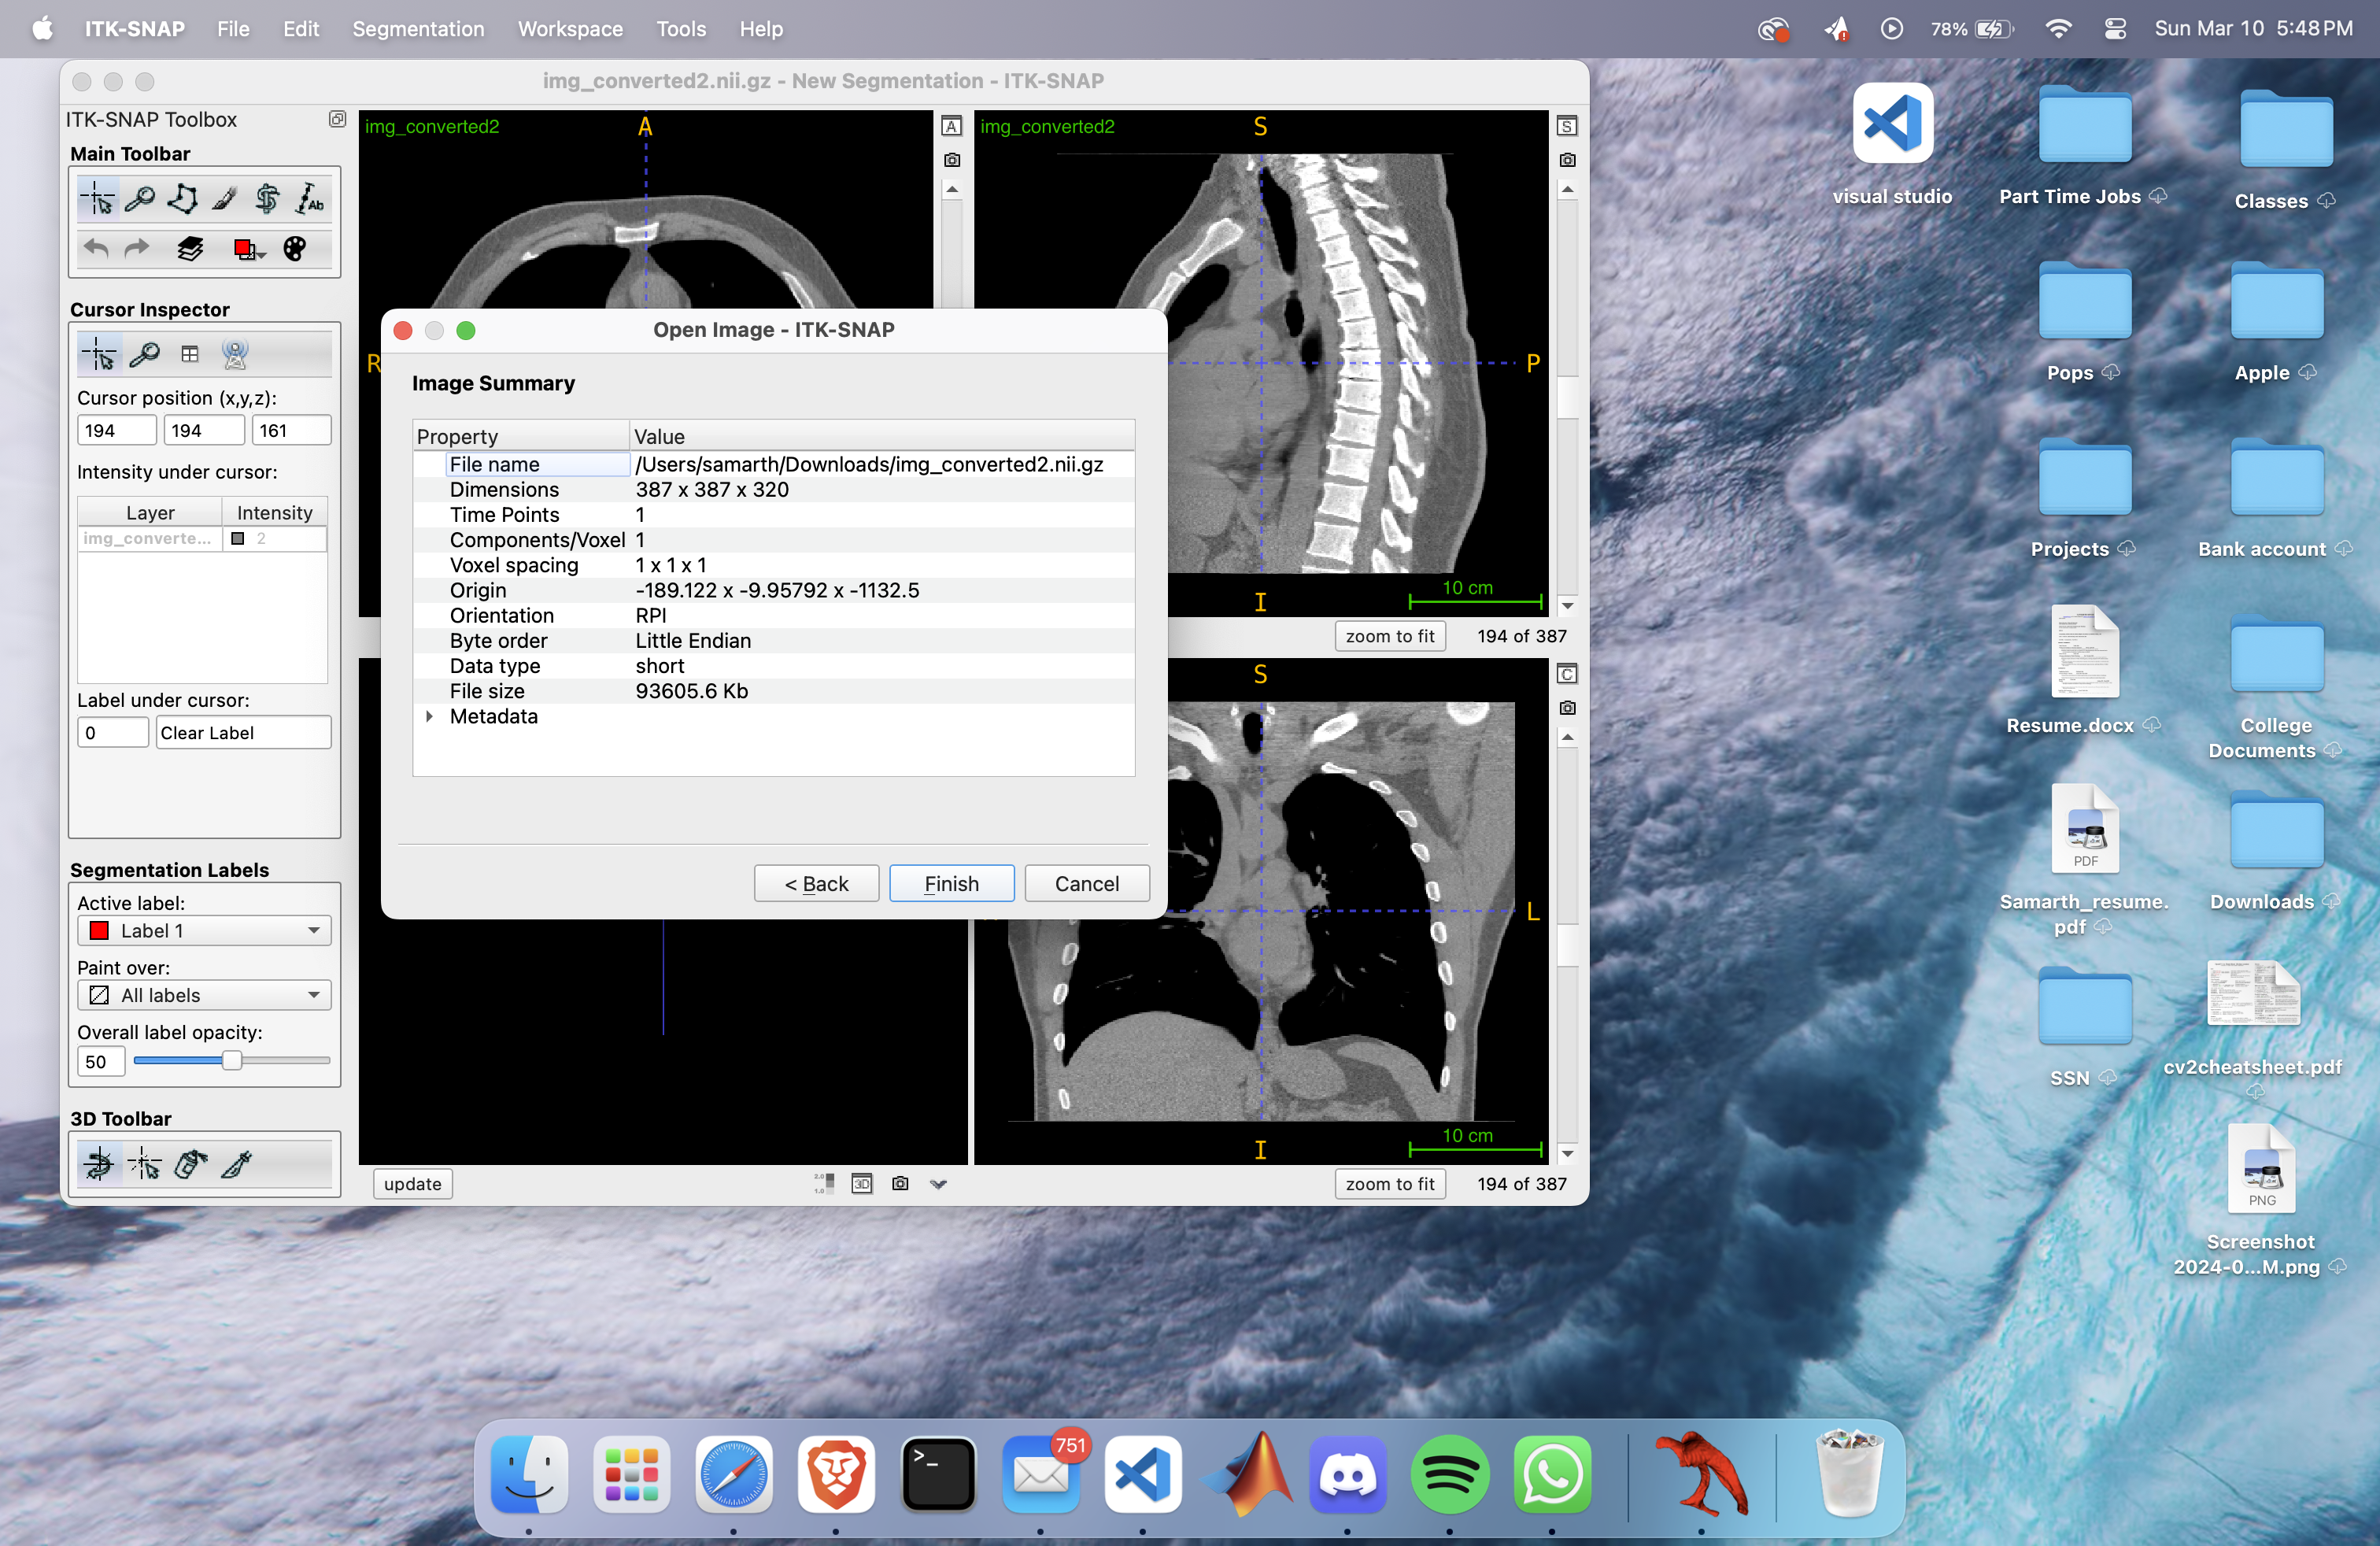

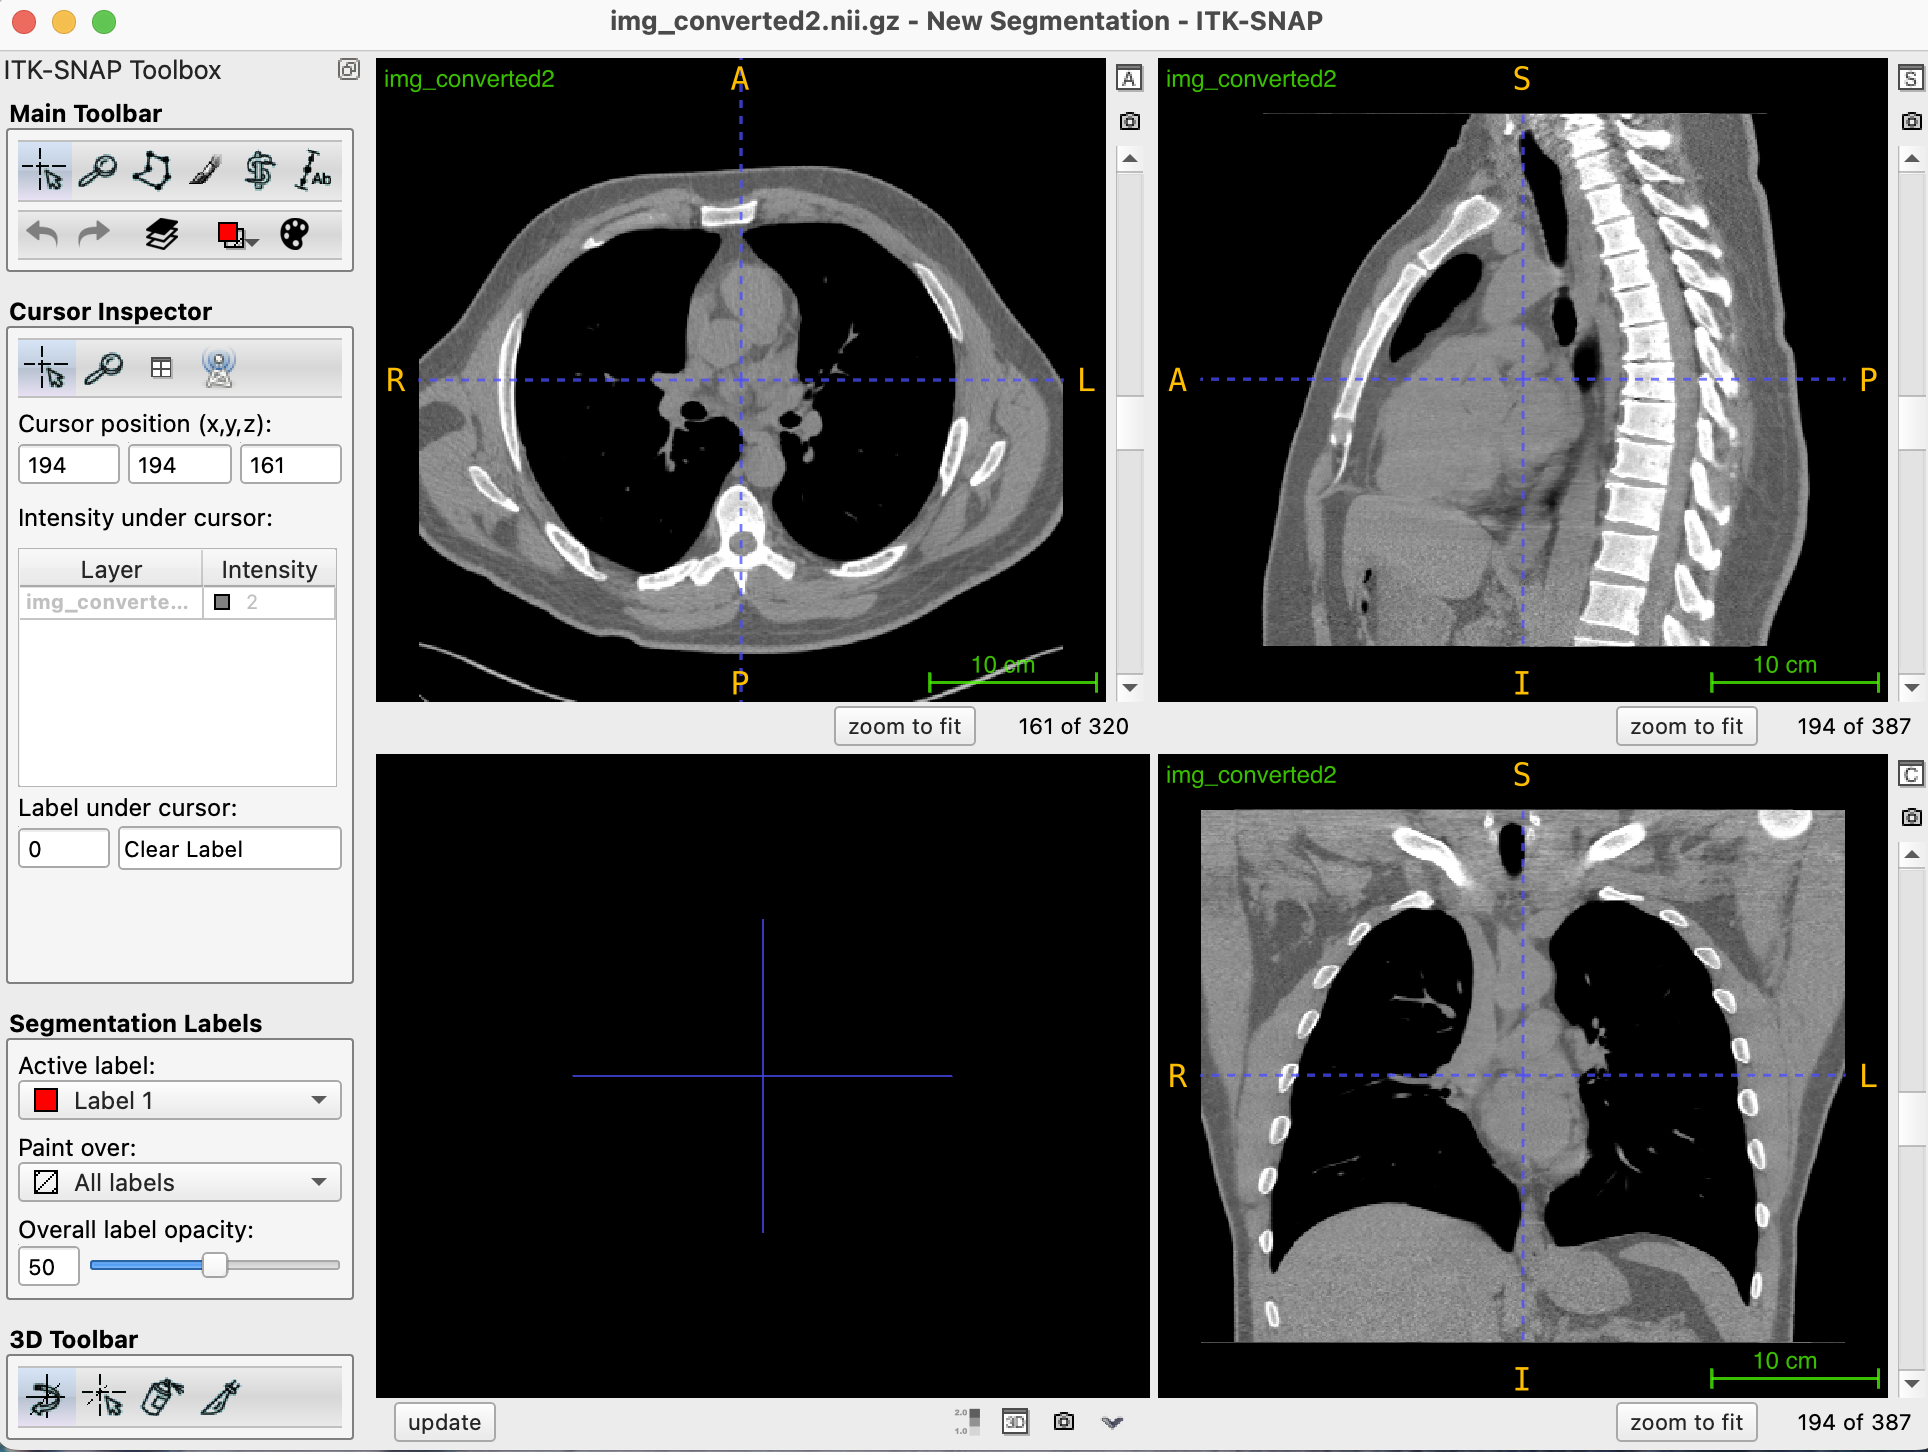

In [29]:
from IPython.display import display, Image
display(Image(filename='/content/image1.jpeg'))
display(Image(filename='/content/image2.jpeg'))

# Exercise 4. Chest X-ray Classification with MONAI (40 points)

MONAI (Medical Open Network for AI) is an open-source framework designed for healthcare imaging research and development. It provides domain-specific components and workflows for deep learning in medical imaging, aiming to accelerate the development and deployment of AI models in healthcare. Focusing on 3 common chest radiographic observations ('No Finding,' 'Pleural Effusion,' and 'Consolidation'), we will utilize MONAI to perform classification on a subset of the larger public dataset for chest radiograph interpretation known as [CheXpert](https://stanfordmlgroup.github.io/competitions/chexpert/).

You can read more about pleural effusion [here](https://www.radiologymasterclass.co.uk/tutorials/chest/chest_pathology/chest_pathology_page4#:~:text=Pleural%20effusions,-A%20pleural%20effusion&text=Fluid%20gathers%20in%20the%20lowest,or%20all%20of%20the%20hemidiaphragm.) and consolidation [here](https://www.radiologymasterclass.co.uk/tutorials/chest/chest_pathology/chest_pathology_page3).

We recommend to do this part on SCC rather than Colab, because it has more powerful GPUs.

### Check GPU status

In [30]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

### Setup imports

In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, resnet18, resnet34, resnet50, SEResNet50, EfficientNetBN
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    Compose,
)
from monai.utils import set_determinism

# print_config()

Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'


### Set deterministic training for reproducibility

In [ ]:
set_determinism(seed = 42)

### 4.1.1. Split the Dataset into Training, Validation, and Testing Sets

Split the dataset with the following distributions:

*   Training - 70%
*   Validation - 10%
*   Testing - 20%

**Hint:** You can use the *train_test_split* function from sklearn.model_selection

In [ ]:
# Read in train.csv on SCC
new_dataset = pd.read_csv('/projectnb/ec500kb/materials/hw2/train.csv')

# Define label mapping
label_map = {'No Finding': 0, 'Pleural Effusion': 1, 'Consolidation': 2}
new_dataset['Label'] = new_dataset['Finding Labels'].map(label_map)

new_dataset_x = new_dataset['Path'].tolist()
new_dataset_y = new_dataset['Label'].tolist()


## -- ! code required
train_data, testval_data, train_labels, testval_labels =
test_data, val_data, test_labels, val_labels =

### 4.1.2. Define MONAI transforms, Dataset, and Dataloader to pre-process the data

Using MONAI's Compose function, define the transform for training data as:

    *   Load the input image
    *   Ensure that the channel dimension is the first dimension in the input image tensor
    *   Scale the intensity values of the input image
    *   Resize the image to a spatial size of 64 x 64
    *   Randomly rotate the input image within the range (in radians) of  pi / 12 along the x-axis. The rotation should be applied with a probability of 0.5 and the size of the image should be kept constant
    *   Randomly flip the input image along the spatial axis (along the first dimension). The flip should be applied with a probability of 0.5
    *   Randomly zoom the input image within the specified zoom range of 0.9 - 1.1. The zoom is applied with a probability of 0.5

**Hint:** Read about MONAI's Compose function [here](https://docs.monai.io/en/stable/transforms.html#monai.transforms.Compose).

and define the transform for validation (and testing) data as:
    
     *  Load the input image
     *  Ensure that the channel dimension is the first dimension in the input image tensor
     *  Scale the intensity values of the input image
     
 Additionally use MONAI's Compose function to post-process the predicted output as:
   
     *  the softmax activation function to the predicted output tensor, converting it into a probability distribution
     
 and post-process the ground truth output as:

     *  converting the ground truth labels into a discrete representation, one-hot encoded, with the specified number of classes (num_class)

**Hint:** Use *AsDiscrete* from MONAI


In [ ]:
train_transforms = Compose([
    ## -- ! code required


])

val_transforms = Compose([
    ## -- ! code required


])


# Softmax activation function
y_pred_trans = ## -- ! code required

# convert label index into onehot representation
y_trans = ## -- ! code required


In [ ]:
class NIHDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):

        # The images are stored on SCC
        base_dir = "/projectnb/ec500kb/materials/"

        image_path = os.path.join(base_dir, self.image_files[index])

        return self.transforms(image_path), self.labels[index]

In [ ]:
train_ds = NIHDataset(train_data, train_labels, train_transforms)
train_loader = DataLoader(train_ds, batch_size = 50, shuffle = True, num_workers = 10)

val_ds = NIHDataset(val_data, val_labels, val_transforms)
val_loader = DataLoader(val_ds, batch_size = 50, num_workers = 10)

test_ds = NIHDataset(test_data, test_labels, val_transforms)
test_loader = DataLoader(test_ds, batch_size = 50, num_workers = 10)

### 4.1.3. Define the network and optimizer

Define the network as:

    *  model - EfficientNetBN (specifically "efficientnet-b7") from MONAI and move to GPU device
    *  loss function - Cross Entropy Loss
    *  optimizer - use the Adam optimizer with a learning rate of 1e-5

For how to initialize model and optimizer with MONAI, you can refer to the notebook [here](https://github.com/Project-MONAI/tutorials/blob/main/3d_classification/densenet_training_array.ipynb).

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ## -- ! code required
loss_function = ## -- ! code required
optimizer = ## -- ! code required

max_epochs = 55
val_interval = 1
auc_metric = ROCAUCMetric()

### 4.1.4. Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  

We will save the model weights to file if got best validation accuracy.

In [ ]:
root_dir = "./hw2_results/"
os.makedirs(root_dir)

def train(root_dir):
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            ## -- ! code required




            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
            epoch_len = len(train_ds) // train_loader.batch_size
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                y_pred = torch.tensor([], dtype = torch.float32, device = device)
                y = torch.tensor([], dtype = torch.long, device = device)
                for val_data in val_loader:
                    val_images, val_labels = (
                        val_data[0].to(device),
                        val_data[1].to(device),
                    )
                    y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                    y = torch.cat([y, val_labels], dim = 0)
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach = False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                auc_metric.reset()
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim = 1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best AUC: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )

    print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
    return best_metric, best_metric_epoch, epoch_loss_values, metric_values

best_metric, best_metric_epoch, epoch_loss_values, metric_values = train(root_dir)

### Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### 4.1.5. Evaluate the model on test dataset

After training and validation, we've already gotten the best model on the validation test. But we still need to evaluate the model on the test dataset to check whether it's robust and not over-fitting.  

Then we'll use these predictions to generate a classification report.

In [ ]:
def eval_model(root_dir):
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    y_true = []
    y_pred = []
    y_pred_logit = []

    with torch.no_grad():
        for test_data in test_loader:
            ## -- ! code required


    y_pred_logit = np.concatenate(y_pred_logit)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred

y_true, y_pred = eval_model(root_dir)

In [ ]:
class_names = ['No Finding', 'Pleural Effusion', 'Consolidation']
print(classification_report(y_true, y_pred, target_names = class_names, digits = 4))

### Plot the precision, recall, thresholds for each class

In [ ]:
for i in range(len(class_names)):
    precision, recall, thresholds = precision_recall_curve(y_true == i, y_pred_logit[:, i])

    # Plot the precision-recall curve
    plt.figure(figsize = (8, 6))
    plt.plot(recall, precision, label = 'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve for class {}'.format(class_names[i]))
    plt.legend()
    plt.show()

### 4.1.6. Balancing Data for Training

Since the distribution of labels for this dataset is imbalanced, the performance of the underrepresented class may be lower than other classes.
Let's attempt to balance the training dataset within the Dataloader.

Specificlly, we can calculate the percentage of samples for each class in the dataset, and then taking the inverse of these probabilities as weights for each sample that belongs to a specific class. In this way, samples from the underrepresented class are oversampled, and samples from the overrepresented class are subsampled.

In the code block below, create a *WeightedRandomSampler* instance that adopt the resampling weight described above.

In [ ]:
from torch.utils.data import WeightedRandomSampler

# Your code below

sampler =

In [ ]:
# apply the sampler to training data loader
train_loader = DataLoader(train_ds, batch_size = 50, shuffle = False, num_workers = 10, sampler = sampler)

# re-initialize the model and the optimizer
# Your code below
model =
optimizer =

### Model training with the resampler

In [ ]:
root_dir = "./hw2_results_resample/"
os.makedirs(root_dir)

best_metric, best_metric_epoch, epoch_loss_values, metric_values = train(root_dir)

### Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [ ]:
y_true, y_pred = eval_model(root_dir)

In [ ]:
class_names = ['No Finding', 'Pleural Effusion', 'Consolidation']
print(classification_report(y_true, y_pred, target_names = class_names, digits = 4))

### Plot the precision, recall, thresholds for each class

In [ ]:
for i in range(len(class_names)):
    precision, recall, thresholds = precision_recall_curve(y_true == i, y_pred_logit[:, i])

    # Plot the precision-recall curve
    plt.figure(figsize = (8, 6))
    plt.plot(recall, precision, label = 'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve for class {}'.format(class_names[i]))
    plt.legend()
    plt.show()

### 4.1.7. Comparison of Results from Balancing vs Not Balancing the Training Dataset within the DataLoader

Please comment on the your findings, comparing the results from balancing vs not balancing the training dataset within the DataLoader, especially on the underrepresented class.

**Comparison:**